### 1.加载数据集

In [2]:
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import pandas as pd

# 下载 NLTK 停用词库
nltk.download('stopwords')  # 确保停用词库已下载
stop_words = set(stopwords.words('english'))

# 加载 IMDB 数据集
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

# 创建一个反向映射词典
word_index = tf.keras.datasets.imdb.get_word_index()

# 反向映射字典
index_word = {index: word for word, index in word_index.items()}

# 将电影评论的数字转为单词
train_texts = [' '.join([index_word.get(i - 3, '?') for i in review]) for review in train_data]
test_texts = [' '.join([index_word.get(i - 3, '?') for i in review]) for review in test_data]

# 合并训练和测试数据
texts = train_texts + test_texts
labels = list(train_labels) + list(test_labels)

# 将数据转换为 DataFrame
df = pd.DataFrame({
    'text': texts,
    'category': labels  # 电影评论的标签：0（负面评论）和 1（正面评论）
})

# 显示前几行数据
print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  category
0  ? this film was just brilliant casting locatio...         1
1  ? big hair big boobs bad music and a giant saf...         0
2  ? this has to be one of the worst films of the...         0
3  ? the ? ? at storytelling the traditional sort...         1
4  ? worst mistake of my life br br i picked this...         0


### 2.数据清理

In [3]:
import re
import numpy as np

def load_word_vectors(file_path):
    word_vectors = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array([float(i) for i in parts[1:]], dtype=np.float32)
            word_vectors[word] = vector
    return word_vectors

# 假设训练好的词向量存储在 word2vec.txt 文件中
word_vectors = load_word_vectors('../txt/word2vec_vectors_50d.txt')

# 定义文本清理函数
def clean_text(text):
    # 转小写
    text = text.lower()

    # 去除标点符号和非字母字符（可选保留数字）
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # 按空格分词
    words = text.split()

    # 去除停用词
    cleaned_words = [word for word in words if word not in stop_words]

    # 重新组合为字符串
    cleaned_text = ' '.join(cleaned_words)

    # 去除多余的空格
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

# 清理所有文本数据
texts = df['text'].apply(clean_text)
df['cleaned_text'] = texts

# 显示前几行数据查看清理结果
df.head()

,text,category,cleaned_text
0,? this film was just brilliant casting locatio...,1,film brilliant casting location scenery story ...
1,? big hair big boobs bad music and a giant saf...,0,big hair big boobs bad music giant safety pin ...
2,? this has to be one of the worst films of the...,0,one worst films 1990s friends watching film ta...
3,? the ? ? at storytelling the traditional sort...,1,storytelling traditional sort many years event...
4,? worst mistake of my life br br i picked this...,0,worst mistake life br br picked movie target 5...


### 3.转为词向量

In [4]:
import torch
import numpy as np
texts = df['cleaned_text']

# 文本分类的标签
labels = df['category'].values  # 这是数字标签，0 - 1（正负面评论）

# Text-CNN 参数
embedding_size = 50  # 词向量维度
sequence_length = 100  # 句子的最大长度
num_classes = 2  # 正负面评论分类
filter_sizes = [3, 4, 5]  
num_filters = 200  # 卷积核数量

def get_input(texts):
    # 创建输入词向量
    inputs = []
    for sen in texts:
        sentence_vector = []
        for word in sen.split():
            # 使用读取的词向量字典来获取每个单词的词向量
            if word in word_vectors:
                sentence_vector.append(word_vectors[word])  # 获取词向量
            else:
                sentence_vector.append(np.zeros(embedding_size))  # 如果词不在词汇表中，使用零向量
        if len(sentence_vector) < sequence_length:
            sentence_vector.extend([np.zeros(embedding_size)] * (sequence_length - len(sentence_vector)))
        else:
            sentence_vector = sentence_vector[:sequence_length]
        inputs.append(np.array(sentence_vector))
    return inputs

# 将 inputs 列表转换为一个 numpy 数组
inputs_array = np.array(get_input(texts))

# 然后再转换为 PyTorch 张量
inputs_tensor = torch.FloatTensor(inputs_array)

# 标签转换为 PyTorch 张量
labels_tensor = torch.LongTensor(labels)

# 显示输入的形状
print(inputs_tensor.shape)  # (batch_size, sequence_length, embedding_size)
print(labels_tensor.shape)  # (batch_size,)

torch.Size([50000, 100, 50])
torch.Size([50000])


### 初始模型

In [5]:
import torch
import torch.nn as nn

class TextCNN(nn.Module):
    def __init__(self, embedding_size, num_classes, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        
        # 卷积层
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_size)) for fs in filter_sizes
        ])
        # 全连接层
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
    
    def forward(self, x):
        # x.shape: (batch_size, sequence_length, embedding_size)
        x = x.unsqueeze(1)  # 增加一个维度: (batch_size, 1, sequence_length, embedding_size)
        # 卷积层
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        # 池化层
        pool_results = [F.max_pool1d(result, result.size(2)).squeeze(2) for result in conv_results]
        # 拼接池化后的结果
        x = torch.cat(pool_results, 1)
        # 全连接层
        x = self.fc(x)
        
        return x

# 初始化模型
model = TextCNN(embedding_size=embedding_size, num_classes=num_classes, 
                filter_sizes=filter_sizes, num_filters=num_filters)

# 输出模型结构
print(model)


TextCNN(
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 50), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 50), stride=(1, 1))
  )
  (fc): Linear(in_features=600, out_features=2, bias=True)
)


In [6]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# 训练集和测试集分割
X_train, X_test, y_train, y_test = train_test_split(inputs_tensor, labels_tensor, test_size=0.2)

# 转换为 DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 模型、损失函数、优化器
model = TextCNN(embedding_size, num_classes, filter_sizes, num_filters)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# 训练过程
for epoch in range(10):  # 假设训练10个epoch
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader)}")
    
torch.save(model.state_dict(), '../model/txtcnn_model.pth')

Epoch [1/10], Loss: 0.3753237753391266
Epoch [2/10], Loss: 0.2799829879045486
Epoch [3/10], Loss: 0.21112805968523027
Epoch [4/10], Loss: 0.1372157945394516
Epoch [5/10], Loss: 0.07574364502131939
Epoch [6/10], Loss: 0.0346505797162652
Epoch [7/10], Loss: 0.015641946098580956
Epoch [8/10], Loss: 0.006817438249289989
Epoch [9/10], Loss: 0.0034980272775515914
Epoch [10/10], Loss: 0.002122074376605451


In [18]:
# 测试过程
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy*100:.2f}%")


Accuracy: 86.31%


In [1]:
import torch
import numpy as np
import re


# 用户输入文本
user_input = input("请输入待分类的文本：")

# 清理用户输入的文本
cleaned_input = clean_text(user_input)

# 将清理后的文本传给 get_input 函数，它期望的是一个列表
sentence_vector = get_input([cleaned_input])  # Wrap in a list

# 转换为 PyTorch 张量
input_tensor = torch.FloatTensor(np.array(sentence_vector))
model = torch.load('../model/txtcnn_model.pth')
model.eval()
# 直接使用模型进行预测
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

# 显示预测结果
if predicted.item() == 0:
    print("预测结果：负面评论")
else:
    print("预测结果：正面评论")


NameError: name 'clean_text' is not defined

### **K折交叉验证**

In [7]:
import torch
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

# KFold 交叉验证
kf = KFold(n_splits=3, shuffle=True, random_state=42)


# 初始化模型结构
def get_model():
    return TextCNN(embedding_size=embedding_size, num_classes=num_classes, 
                   filter_sizes=filter_sizes, num_filters=num_filters)

# 存储每折的准确率
accuracies = []

# 进行3折交叉验证
for fold, (train_idx, val_idx) in enumerate(kf.split(inputs_tensor)):
    print(f"Fold {fold+1}/{3}")
    
    # 划分训练集和验证集
    X_train, X_val = inputs_tensor[train_idx], inputs_tensor[val_idx]
    y_train, y_val = labels_tensor[train_idx], labels_tensor[val_idx]
    
    # 转换为 DataLoader
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    
    # 初始化模型、损失函数和优化器
    model = get_model()
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    # 训练过程
    for epoch in range(10):  # 假设训练10个epoch
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader)}")
    
    # 验证过程
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy for fold {fold+1}: {accuracy*100:.2f}%")
    accuracies.append(accuracy)

# 输出每折的准确率和平均准确率
print(f"Cross-validation accuracies: {accuracies}")
print(f"Average accuracy: {np.mean(accuracies)*100:.2f}%")


Fold 1/3
Epoch [1/10], Loss: 0.3885237242232815
Epoch [2/10], Loss: 0.28814105901173576
Epoch [3/10], Loss: 0.22602445173172026
Epoch [4/10], Loss: 0.13791879290811387
Epoch [5/10], Loss: 0.07947564514035685
Epoch [6/10], Loss: 0.037718383309336634
Epoch [7/10], Loss: 0.01585752837942652
Epoch [8/10], Loss: 0.0070159498279495965
Epoch [9/10], Loss: 0.004085337655125418
Epoch [10/10], Loss: 0.002722282371315712
Accuracy for fold 1: 86.48%
Fold 2/3
Epoch [1/10], Loss: 0.37667738759243097
Epoch [2/10], Loss: 0.2810890662149596
Epoch [3/10], Loss: 0.21251247480025448
Epoch [4/10], Loss: 0.13091752686736222
Epoch [5/10], Loss: 0.07702872944699024
Epoch [6/10], Loss: 0.032805770696382144
Epoch [7/10], Loss: 0.013867071173699026
Epoch [8/10], Loss: 0.006707710199211786
Epoch [9/10], Loss: 0.0038821245798387077
Epoch [10/10], Loss: 0.002579109253667495
Accuracy for fold 2: 85.86%
Fold 3/3
Epoch [1/10], Loss: 0.38131214486660286
Epoch [2/10], Loss: 0.28435938742419353
Epoch [3/10], Loss: 0.2075

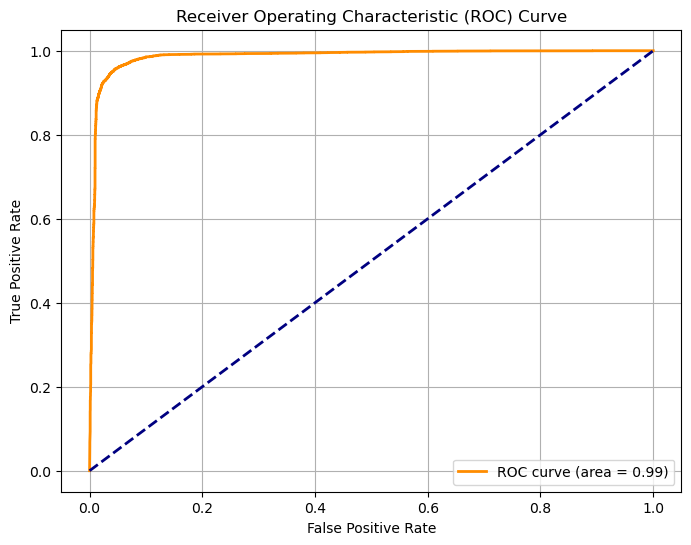

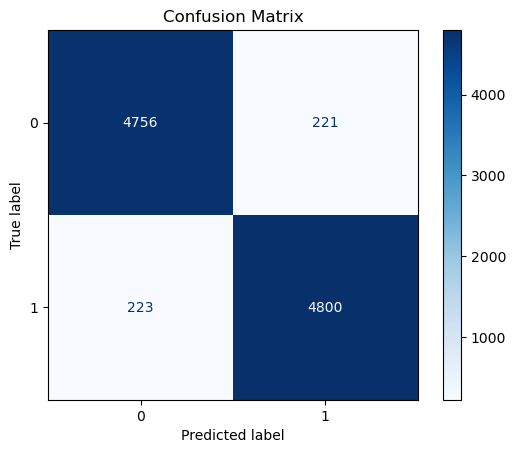

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 测试过程
model.eval()
y_true = []
y_pred = []
# 测试集预测
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        
        # 获取预测的概率
        probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # 预测为类别1的概率
        y_pred.extend(probs)
        y_true.extend(labels.cpu().numpy())
# 计算 ROC 曲线
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 获取模型的预测标签
y_pred_labels = [1 if p > 0.5 else 0 for p in y_pred]
# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred_labels)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### **使用网格搜索进行调优**
>        网格搜索是一种暴力搜索方法，它会遍历你给定的超参数空间的所有组合，进行训练并评估模型的表现。通常来说，网格搜索适用于超参数空间较小的情况，因为它的计算量随着参数空间的增 大而指数级增长。
>
**优点**：找到全局最优超参数组合。适用于超参数组合较小的情况。

**缺点**：计算量大，效率低，尤其是在超参数空间较大时。

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# 1. 定义 TextCNN 模型
class TextCNN(nn.Module):
    def __init__(self, embedding_size, num_classes, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters, (fs, embedding_size)) for fs in filter_sizes])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加一个维度: (batch_size, 1, sequence_length, embedding_size)
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pool_results = [F.max_pool1d(result, result.size(2)).squeeze(2) for result in conv_results]
        x = torch.cat(pool_results, 1)
        x = self.fc(x)
        return x

# 2. 定义 PyTorch 分类器包装器
class TextCNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_size=50, num_classes=2, filter_sizes=[3, 4, 5], num_filters=100, batch_size=64, epochs=3, learning_rate=0.001):
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

    def fit(self, X, y):
        # 将数据转换为 PyTorch 张量
        inputs_tensor = torch.FloatTensor(X)
        labels_tensor = torch.LongTensor(y)
        
        # 创建训练 DataLoader
        train_data = TensorDataset(inputs_tensor, labels_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        # 初始化模型
        self.model = TextCNN(embedding_size=self.embedding_size, num_classes=self.num_classes, 
                             filter_sizes=self.filter_sizes, num_filters=self.num_filters)
        
        # 损失函数和优化器
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # 训练过程
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            for batch in train_loader:
                inputs, labels = batch
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {total_loss/len(train_loader)}")

        return self

    def predict(self, X):
        # 转换测试数据为 PyTorch 张量
        inputs_tensor = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs_tensor)
            _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

param_grid = {
    'embedding_size': [50, 100],
    'filter_sizes': [[3, 4, 5]],
    'num_filters': [100, 200],
    'batch_size': [64],
    'epochs': [3, 5],
    'learning_rate': [0.001]
}

# 4. 使用 GridSearchCV 进行超参数优化
X = np.array(inputs_array)  # 假设你已经处理好的输入数据
y = labels  # 标签

model = TextCNNClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

# 执行网格搜索
grid_search.fit(X, y)

# 输出最佳参数和最优模型
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch [1/3], Loss: 0.37972732397393394
Epoch [2/3], Loss: 0.28757173312030687
Epoch [3/3], Loss: 0.2363494388802038
Epoch [1/3], Loss: 0.3811265845388003
Epoch [2/3], Loss: 0.29323162513136175
Epoch [3/3], Loss: 0.23660212936820088
Epoch [1/3], Loss: 0.37995194078864614
Epoch [2/3], Loss: 0.2940780831904878
Epoch [3/3], Loss: 0.2391886145534305
Epoch [1/3], Loss: 0.38042158214464755
Epoch [2/3], Loss: 0.27686568576978404
Epoch [3/3], Loss: 0.20592009281871873
Epoch [1/3], Loss: 0.3868167951788875
Epoch [2/3], Loss: 0.28601927972343283
Epoch [3/3], Loss: 0.20804361302598653
Epoch [1/3], Loss: 0.38710368686353863
Epoch [2/3], Loss: 0.28325428030026395
Epoch [3/3], Loss: 0.21480519218717106
Epoch [1/5], Loss: 0.3822633534555472
Epoch [2/5], Loss: 0.2873317875296964
Epoch [3/5], Loss: 0.22860506703208366
Epoch [4/5], Loss: 0.1702880819333492
Epoch [5/5], Loss: 0.10948719975186401
Epoch [1/5], Loss: 0.380778047064902
Epoch [2/5], L

F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_17384\1570113766.py", line 60, in fit
    outputs = self.model(inputs)
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\torch\nn\modules\module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwa

Epoch [1/3], Loss: 0.3713576466111881
Epoch [2/3], Loss: 0.2836043509318853
Epoch [3/3], Loss: 0.2241312291311181
Best Parameters: {'batch_size': 64, 'embedding_size': 50, 'epochs': 3, 'filter_sizes': [3, 4, 5], 'learning_rate': 0.001, 'num_filters': 200}
Best Score: 0.8579600362870937


In [ ]:
Best Parameters: {'batch_size': 64, 'embedding_size': 50, 'epochs': 3, 'filter_sizes': [3, 4, 5], 'learning_rate': 0.001, 'num_filters': 200}
Best Score: 0.8579600362870937

In [ ]:
torch.save(model, "model/txtCNN_grid_search.pth")

### **使用随机搜索进行调优**
>  随机搜索通过随机选择一组超参数进行评估，并重复这一过程。与网格搜索不同，随机搜索不会遍历所有可能的超参数组合，而是随机地从给定的超参数分布中抽取一些值进行训练。这样可以在有限的时间和计算资源内找到一个较好的超参数组合，尤其是在超参数空间很大的情况下。
> 
**优点**:更高效，能够更快地找到一个不错的超参数组合 

**缺点**:不能保证找到全局最优的超参数组合  


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from scipy.stats import randint

# 1. 定义 TextCNN 模型
class TextCNN(nn.Module):
    def __init__(self, embedding_size, num_classes, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters, (fs, embedding_size)) for fs in filter_sizes])
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加一个维度: (batch_size, 1, sequence_length, embedding_size)
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pool_results = [F.max_pool1d(result, result.size(2)).squeeze(2) for result in conv_results]
        x = torch.cat(pool_results, 1)
        x = self.fc(x)
        return x

# 2. 定义 PyTorch 分类器包装器
class TextCNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_size=50, num_classes=2, filter_sizes=[3, 4, 5], num_filters=100, batch_size=64, epochs=3, learning_rate=0.001):
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate

    def fit(self, X, y):
        # 将数据转换为 PyTorch 张量
        inputs_tensor = torch.FloatTensor(X)
        labels_tensor = torch.LongTensor(y)
        
        # 创建训练 DataLoader
        train_data = TensorDataset(inputs_tensor, labels_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        # 初始化模型
        self.model = TextCNN(embedding_size=self.embedding_size, num_classes=self.num_classes, 
                             filter_sizes=self.filter_sizes, num_filters=self.num_filters)
        
        # 损失函数和优化器
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # 训练过程
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            for batch in train_loader:
                inputs, labels = batch
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {total_loss/len(train_loader)}")

        return self

    def predict(self, X):
        # 转换测试数据为 PyTorch 张量
        inputs_tensor = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs_tensor)
            _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

# 3. 定义超参数搜索空间
param_dist = {
    'embedding_size': [50, 100, 200],
    'filter_sizes': [[3, 4, 5]],
    'num_filters': randint(50, 200),  # 使用整数范围
    'batch_size': [64],
    'epochs': [3, 5, 10],
    'learning_rate': [0.001]
}

# 4. 使用 RandomizedSearchCV 进行超参数优化
X = inputs_tensor
y = labels_tensor  # 标签

model = TextCNNClassifier()

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=3, verbose=1, n_jobs=1, random_state=42)

# 执行随机搜索
random_search.fit(X, y)

# 输出最佳参数和最优模型
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Epoch [1/10], Loss: 0.37776578665351684
Epoch [2/10], Loss: 0.2836385650735441
Epoch [3/10], Loss: 0.22315224543242446
Epoch [4/10], Loss: 0.1602532844168211
Epoch [5/10], Loss: 0.10339527317607014
Epoch [6/10], Loss: 0.059340131828371945
Epoch [7/10], Loss: 0.033498178221885964
Epoch [8/10], Loss: 0.016526341691234233
Epoch [9/10], Loss: 0.008868203501104451
Epoch [10/10], Loss: 0.005409039679875386


F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_17384\4223685448.py", line 81, in score
    accuracy = np.mean(y_pred == y)
  File "<__array_function__ internals>", line 200, in mean
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\numpy\core\fromnumeric.py", line 3462, in mean
    return mean(axis=axis, dtype=dtype, out=out, **kwargs)
TypeError: mean() received an invalid combination of arguments - g

Epoch [1/10], Loss: 0.3770578848537694
Epoch [2/10], Loss: 0.28733265126792573
Epoch [3/10], Loss: 0.22594113187460432
Epoch [4/10], Loss: 0.16712148940894975
Epoch [5/10], Loss: 0.10811986944025057
Epoch [6/10], Loss: 0.06800765361486721
Epoch [7/10], Loss: 0.03918171018512201
Epoch [8/10], Loss: 0.020947774713090308
Epoch [9/10], Loss: 0.011131805213143237
Epoch [10/10], Loss: 0.006574434943268372
Epoch [1/10], Loss: 0.3833905307722641
Epoch [2/10], Loss: 0.2935529378548465
Epoch [3/10], Loss: 0.23398712263111876
Epoch [4/10], Loss: 0.17334380162425783
Epoch [5/10], Loss: 0.11077872431352592
Epoch [6/10], Loss: 0.0672164048334573
Epoch [7/10], Loss: 0.03913312155803426
Epoch [8/10], Loss: 0.021186837528773268
Epoch [9/10], Loss: 0.01209036337976807
Epoch [10/10], Loss: 0.006820692909584736
Epoch [1/10], Loss: 0.3747799733435581
Epoch [2/10], Loss: 0.2764558308613049
Epoch [3/10], Loss: 0.20816679047188238
Epoch [4/10], Loss: 0.12891912076357687
Epoch [5/10], Loss: 0.06892338057626003

F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_17384\4223685448.py", line 61, in fit
    outputs = self.model(inputs)
  File "F:\binbin\app\conda\envs\Pytorch1\lib\site-packages\torch\nn\modules\module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwa

RuntimeError: Calculated padded input size per channel: (100 x 50). Kernel size: (3 x 200). Kernel size can't be greater than actual input size

In [ ]:
torch.save(model, "model/txtCNN_random_search.pth")